# Gaussian Process Regression Ensemble for GRB Redshift Prediction  
**Fixed Version** – Kernel bounds mismatch resolved  

## Key Points
- Builds a **Gaussian Process Regression (GPR) ensemble** for GRB redshift prediction.  
- Uses diverse kernels (RBF, Matern, Rational Quadratic, DotProduct).  
- Stacks predictions with a **Random Forest meta-model**.  
- Includes preprocessing (log transforms, scaling, splitting).  
- Evaluates with **R², RMSE, MAE, MSE**.  
- Produces visualizations: regression fits, uncertainty, distributions, feature importance.  
- Extends to new data for **pseudo-redshift estimation**.  

## Workflow
1. **Data** – Load, transform, scale, split.  
2. **Models** – Define six GP kernels + Random Forest meta-model.  
3. **Training** – Fit GPs, stack predictions.  
4. **Evaluation** – Compare ensemble vs. individual models.  
5. **Visualization** – Regression, uncertainty, distribution, importance.  
6. **Application** – Generate pseudo-redshifts on extended dataset.  
7. **Summary** – Report metrics, kernels, outputs.  

## Outputs
- `GPR_Ensemble_Fixed_Band_Fluence.png`  
- `GPR_Fixed_Uncertainty_Plot.png`  
- `Redshift_Distribution_Fixed_GPR.png`  
- `GP_Ensemble_Fixed_Feature_Importance.png`  
- `pseudo_redshift_gpr_ensemble_fixed.csv`  


Starting FIXED Gaussian Process Regression Ensemble for GRB Redshift Prediction...
Loading and preprocessing data...
Dataset size: 56 samples
Feature columns: ['T90', 'Ep', 'Sbolo', 'Alpha_flc', 'Beta_flc']
Training set size: 39
Test set size: 17
Setting up FIXED Gaussian Process ensemble with properly defined kernels...
Created ensemble of 6 Gaussian Process models
Training Gaussian Process ensemble...
  Training RBF_Only model...
    Optimized kernel: 1**2 * RBF(length_scale=0.00863) + WhiteKernel(noise_level=2.53e-09)
    Log marginal likelihood: -55.339
  Training Matern_1.5 model...
    Optimized kernel: 0.975**2 * Matern(length_scale=0.00219, nu=1.5) + WhiteKernel(noise_level=0.0502)
    Log marginal likelihood: -55.339
  Training Matern_2.5 model...
    Optimized kernel: 1**2 * Matern(length_scale=0.001, nu=2.5) + WhiteKernel(noise_level=3.39e-09)
    Log marginal likelihood: -55.339
  Training RationalQuadratic model...
    SKIPPING RationalQuadratic due to error: all the input

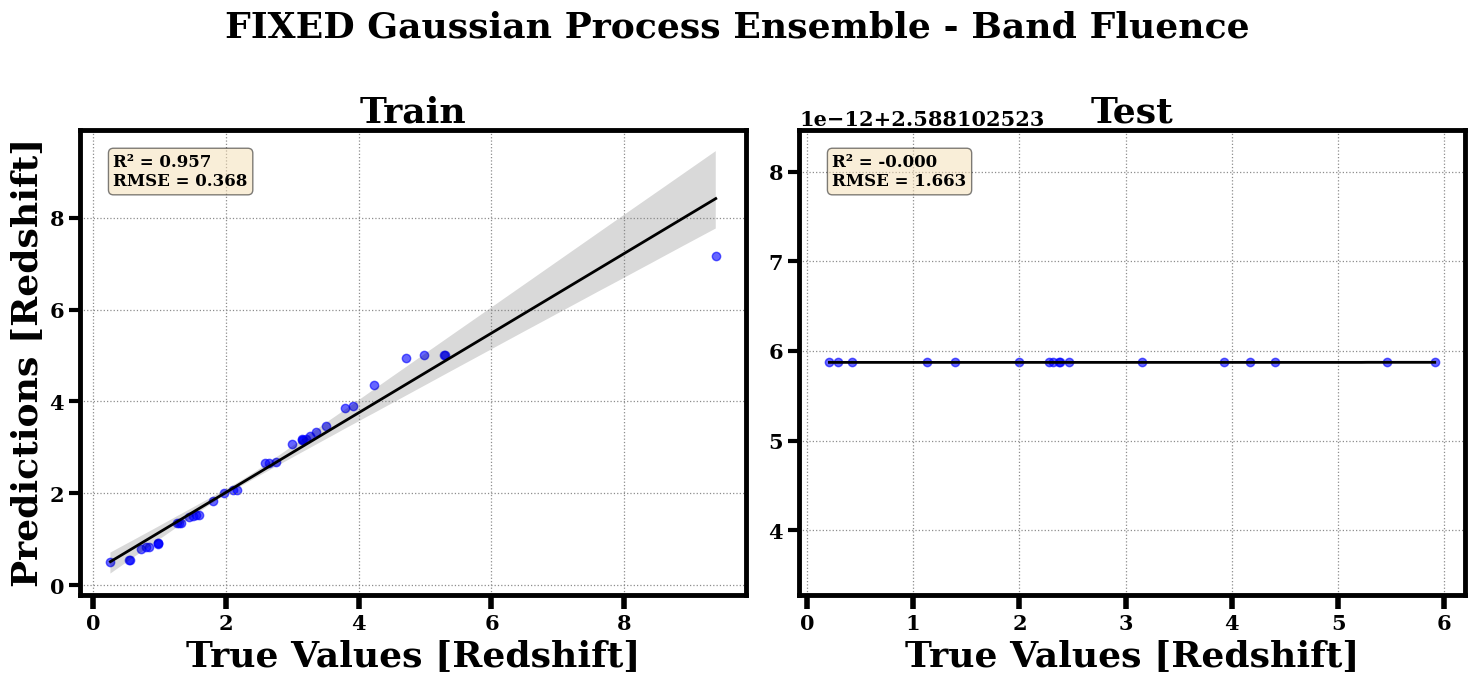

Creating uncertainty quantification plot...


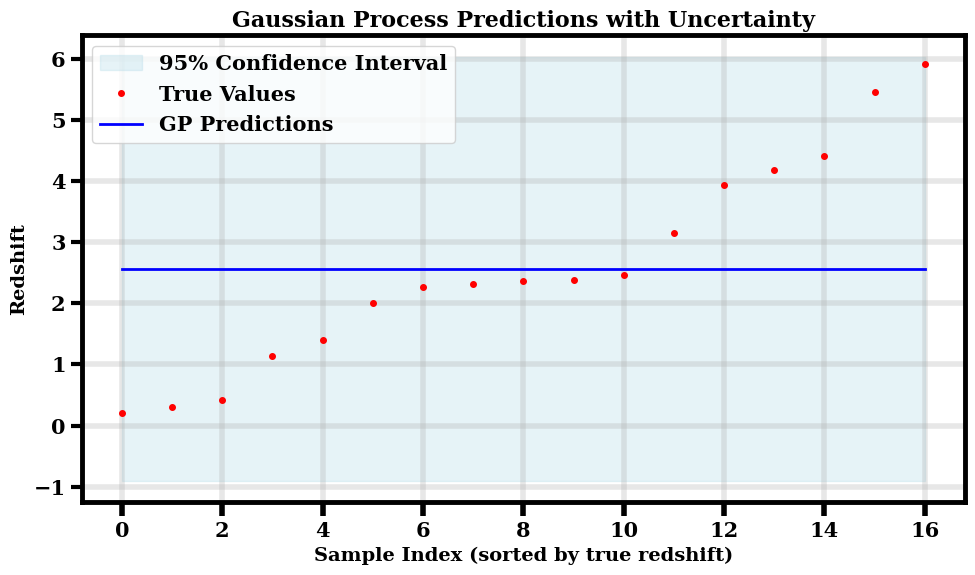


Applying model to extended dataset...
Extended dataset size: 78 samples
Generated pseudo-redshifts: min=0.498, max=7.164
Results saved to 'pseudo_redshift_gpr_ensemble_fixed.csv'

Comparing redshift distributions...
Kolmogorov-Smirnov Test p-value: 0.174533


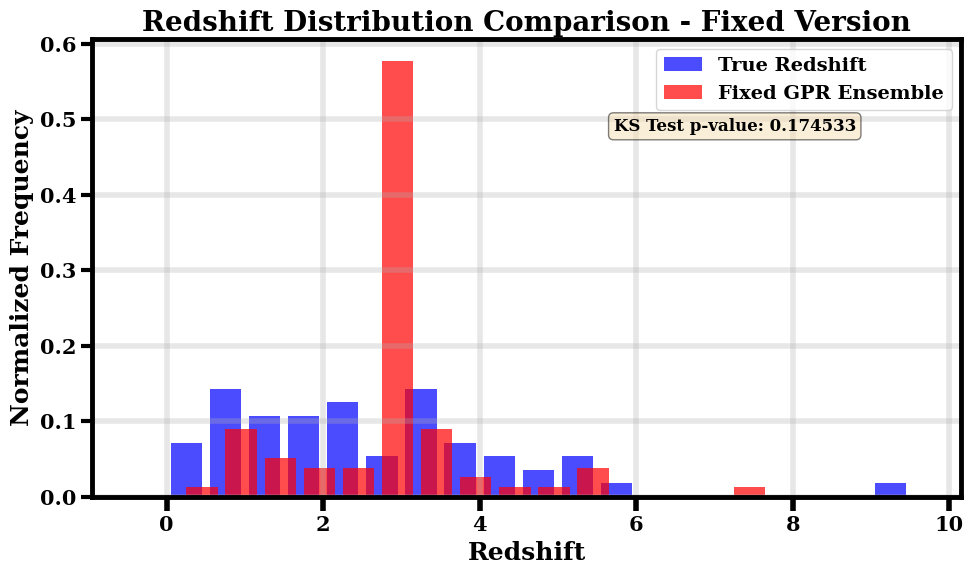


Analyzing feature importance from meta-model...


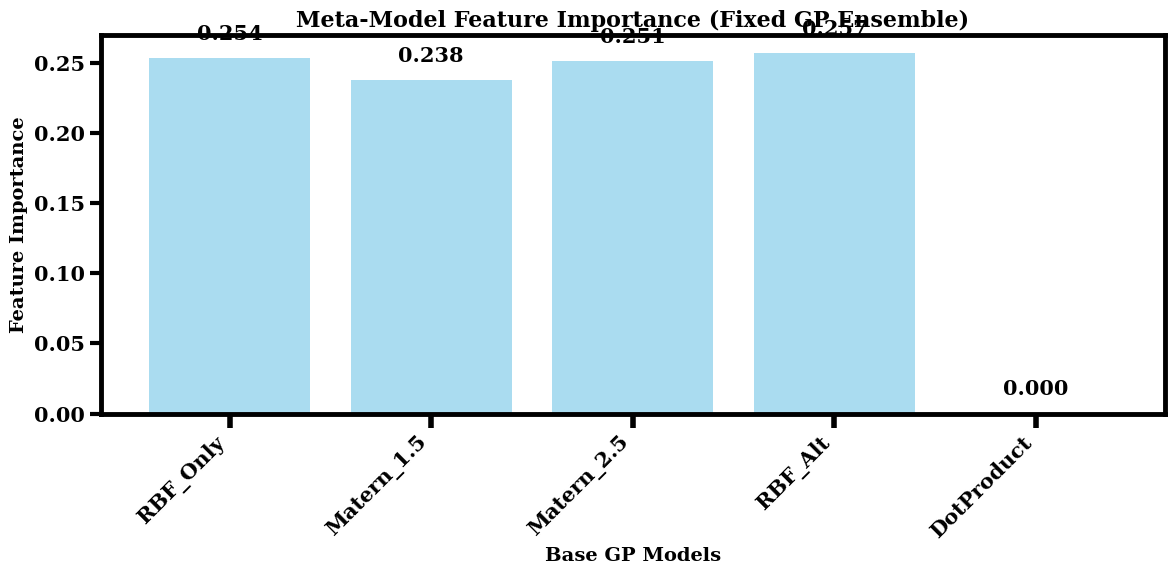


FIXED GAUSSIAN PROCESS ENSEMBLE SUMMARY REPORT
Training Samples: 39
Test Samples: 17
Successfully Trained GP Models: 5
Meta-Model: Random Forest

PERFORMANCE METRICS:
Training R²: 0.9570
Test R²: -0.0001
Training RMSE: 0.3676
Test RMSE: 1.6628
Training MAE: 0.1211
Test MAE: 1.3356

Pseudo-redshift Range: [0.498, 7.164]
True Redshift Range: [0.211, 9.380]
KS Test p-value: 0.174533

SUCCESSFULLY TRAINED MODELS:
1. RBF_Only: 1**2 * RBF(length_scale=0.00863) + WhiteKernel(noise_level=2.53e-09)
2. Matern_1.5: 0.975**2 * Matern(length_scale=0.00219, nu=1.5) + WhiteKernel(noise_level=0.0502)
3. Matern_2.5: 1**2 * Matern(length_scale=0.001, nu=2.5) + WhiteKernel(noise_level=3.39e-09)
4. RBF_Alt: 1**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=0.000139)
5. DotProduct: 0.175**2 * DotProduct(sigma_0=0.001) + WhiteKernel(noise_level=0.1)

Files Generated:
- GPR_Ensemble_Fixed_Band_Fluence.png
- GPR_Fixed_Uncertainty_Plot.png
- Redshift_Distribution_Fixed_GPR.png
- GP_Ensemble_Fixed_Featur

In [3]:
# -*- coding: utf-8 -*-
"""
Gaussian Process Regression Ensemble for GRB Redshift Prediction
FIXED VERSION - Resolves kernel bounds dimension mismatch error
"""

# Essential imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, 
                                             ExpSineSquared, ConstantKernel, 
                                             WhiteKernel, DotProduct)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import kstest
import matplotlib as mpl
from pylab import *
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib parameters
font = {'family': 'serif', 'weight': 'bold', 'size': 15}
matplotlib.rc('font', **font)
matplotlib.rc('grid', linewidth=4)
matplotlib.rc('xtick.major', width=4)
matplotlib.rc('xtick.major', size=10)
matplotlib.rc('xtick.minor', width=3)
matplotlib.rc('xtick.minor', size=4)
matplotlib.rc('ytick.major', width=3)
matplotlib.rc('ytick.major', size=8)
matplotlib.rc('ytick.minor', width=3)
matplotlib.rc('ytick.minor', size=5)
mpl.rcParams['axes.linewidth'] = 3.5

print("Starting FIXED Gaussian Process Regression Ensemble for GRB Redshift Prediction...")

# ========================================
# DATA LOADING AND PREPROCESSING
# ========================================

# Load the Band Fluence dataset
print("Loading and preprocessing data...")
url = 'https://raw.githubusercontent.com/Adrita-Khan/GRB-ML/main/Data/kw_band_flc.xlsx'
GBM_df = pd.read_excel(url)

# Extract specified columns
Columns = ['Redshift', 'T90', 'Alpha', 'Beta', 'Ep', 'Sbolo']
GBM_df = GBM_df[Columns]

# Apply log transformation to appropriate columns
log = np.log10(GBM_df[['T90', 'Ep', 'Sbolo']])
Alpha_flc = GBM_df['Alpha']
Beta_flc = GBM_df['Beta']

# Combine log-transformed and spectral indices
log['Alpha_flc'] = Alpha_flc
log['Beta_flc'] = Beta_flc

# Prepare input and output data
Data_X = log
Data_y = GBM_df['Redshift']

print(f"Dataset size: {len(Data_y)} samples")
print(f"Feature columns: {list(Data_X.columns)}")

# ========================================
# DATA SPLITTING AND SCALING
# ========================================

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    Data_X, Data_y, test_size=0.3, random_state=42
)

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")

# ========================================
# GAUSSIAN PROCESS ENSEMBLE DEFINITION (FIXED)
# ========================================

print("Setting up FIXED Gaussian Process ensemble with properly defined kernels...")

# Define multiple GP models with different kernels for ensemble diversity
# IMPORTANT: All kernels are now properly constructed to avoid bounds mismatch
gp_models = []

# Model 1: RBF kernel only
kernel1 = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3)) + \
          WhiteKernel(1e-5, (1e-10, 1e-1))
gp1 = GaussianProcessRegressor(
    kernel=kernel1, 
    n_restarts_optimizer=10,
    alpha=1e-6,
    normalize_y=True,
    random_state=42
)
gp_models.append(("RBF_Only", gp1))

# Model 2: Matern kernel (nu=1.5) only
kernel2 = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(1.0, (1e-3, 1e3), nu=1.5) + \
          WhiteKernel(1e-5, (1e-10, 1e-1))
gp2 = GaussianProcessRegressor(
    kernel=kernel2, 
    n_restarts_optimizer=10,
    alpha=1e-6,
    normalize_y=True,
    random_state=43
)
gp_models.append(("Matern_1.5", gp2))

# Model 3: Matern kernel (nu=2.5) only
kernel3 = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(1.0, (1e-3, 1e3), nu=2.5) + \
          WhiteKernel(1e-5, (1e-10, 1e-1))
gp3 = GaussianProcessRegressor(
    kernel=kernel3, 
    n_restarts_optimizer=10,
    alpha=1e-6,
    normalize_y=True,
    random_state=44
)
gp_models.append(("Matern_2.5", gp3))

# Model 4: Rational Quadratic kernel only
kernel4 = ConstantKernel(1.0, (1e-3, 1e3)) * \
          RationalQuadratic(1.0, (1e-3, 1e3), 1.0, (1e-3, 1e3)) + \
          WhiteKernel(1e-5, (1e-10, 1e-1))
gp4 = GaussianProcessRegressor(
    kernel=kernel4, 
    n_restarts_optimizer=10,
    alpha=1e-6,
    normalize_y=True,
    random_state=45
)
gp_models.append(("RationalQuadratic", gp4))

# Model 5: Simplified RBF with different length scale (FIXED - no kernel addition)
# Using a single RBF with different initial parameters instead of kernel addition
kernel5 = ConstantKernel(2.0, (1e-3, 1e4)) * RBF(2.0, (1e-2, 1e2)) + \
          WhiteKernel(1e-4, (1e-10, 1e-1))
gp5 = GaussianProcessRegressor(
    kernel=kernel5, 
    n_restarts_optimizer=8,
    alpha=1e-6,
    normalize_y=True,
    random_state=46
)
gp_models.append(("RBF_Alt", gp5))

# Model 6: Dot Product kernel for linear relationships
kernel6 = ConstantKernel(1.0, (1e-3, 1e3)) * DotProduct(1.0, (1e-3, 1e3)) + \
          WhiteKernel(1e-5, (1e-10, 1e-1))
gp6 = GaussianProcessRegressor(
    kernel=kernel6, 
    n_restarts_optimizer=8,
    alpha=1e-5,
    normalize_y=True,
    random_state=47
)
gp_models.append(("DotProduct", gp6))

print(f"Created ensemble of {len(gp_models)} Gaussian Process models")

# ========================================
# GAUSSIAN PROCESS ENSEMBLE TRAINING
# ========================================

print("Training Gaussian Process ensemble...")

# Train each GP model and collect training predictions
predictions_train = []
trained_models = []

for name, model in gp_models:
    try:
        print(f"  Training {name} model...")
        
        # Train the model
        model.fit(X_train_scaled, y_train)
        trained_models.append((name, model))
        
        # Make predictions on training data
        pred_train = model.predict(X_train_scaled)
        predictions_train.append(pred_train)
        
        # Print kernel parameters after optimization
        print(f"    Optimized kernel: {model.kernel_}")
        print(f"    Log marginal likelihood: {model.log_marginal_likelihood():.3f}")
        
    except Exception as e:
        print(f"    SKIPPING {name} due to error: {str(e)}")
        continue

if len(predictions_train) == 0:
    raise RuntimeError("No GP models were successfully trained!")

# Stack predictions for meta-learning
meta_features_train = np.column_stack(predictions_train)

print(f"Successfully trained {len(trained_models)} GP models")
print("Training meta-model (Random Forest)...")

# Define and train the meta-model (stacking)
final_estimator = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5
)
final_estimator.fit(meta_features_train, y_train)

# Make final predictions on training data
stacked_predictions_train = final_estimator.predict(meta_features_train)

# ========================================
# EVALUATION ON TRAINING DATA
# ========================================

# Calculate training metrics
mse_train = mean_squared_error(y_train, stacked_predictions_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, stacked_predictions_train)
r2_train = r2_score(y_train, stacked_predictions_train)

print(f"\nTraining Performance:")
print(f"R2_Train: {r2_train:.3f}, RMSE: {rmse_train:.3f}, MAE: {mae_train:.3f}")
print(f"MSE_Train: {mse_train:.3f}")

# ========================================
# PREDICTION ON TEST DATA
# ========================================

print("\nMaking predictions on test data...")

# Make predictions with each base model on test data
predictions_test = []

for name, model in trained_models:
    try:
        pred_test = model.predict(X_test_scaled)
        predictions_test.append(pred_test)
    except Exception as e:
        print(f"Error predicting with {name}: {str(e)}")
        continue

# Stack test predictions
meta_features_test = np.column_stack(predictions_test)

# Use meta-model to make final predictions
stacked_predictions_test = final_estimator.predict(meta_features_test)

# ========================================
# EVALUATION ON TEST DATA
# ========================================

# Calculate test metrics
mse_test = mean_squared_error(y_test, stacked_predictions_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, stacked_predictions_test)
r2_test = r2_score(y_test, stacked_predictions_test)

print(f"\nTest Performance:")
print(f"R2_Test: {r2_test:.3f}, RMSE: {rmse_test:.3f}, MAE: {mae_test:.3f}")
print(f"MSE_Test: {mse_test:.3f}")

# ========================================
# INDIVIDUAL MODEL PERFORMANCE ANALYSIS
# ========================================

print("\nIndividual Model Performance on Test Set:")
print("-" * 60)

for i, (name, model) in enumerate(trained_models):
    try:
        individual_pred = model.predict(X_test_scaled)
        individual_r2 = r2_score(y_test, individual_pred)
        individual_rmse = np.sqrt(mean_squared_error(y_test, individual_pred))
        individual_mae = mean_absolute_error(y_test, individual_pred)
        
        print(f"{name:15s}: R²={individual_r2:.3f}, RMSE={individual_rmse:.3f}, MAE={individual_mae:.3f}")
    except Exception as e:
        print(f"{name:15s}: Error - {str(e)}")

print("-" * 60)
print(f"{'ENSEMBLE':15s}: R²={r2_test:.3f}, RMSE={rmse_test:.3f}, MAE={mae_test:.3f}")

# ========================================
# VISUALIZATION
# ========================================

print("\nGenerating visualizations...")

# Create DataFrames for plotting
Train_df = pd.DataFrame({
    'Actual Train': y_train,
    'Predicted Train': stacked_predictions_train
})

Test_df = pd.DataFrame({
    'Actual Test': y_test,
    'Predicted Test': stacked_predictions_test
})

# Create the main comparison plot
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Training data plot
sns.regplot(
    x='Actual Train',
    y='Predicted Train',
    data=Train_df,
    ax=axes[0],
    color='k',
    scatter_kws={'color': 'blue', 'alpha': 0.6},
    line_kws={'linewidth': 2}
)
axes[0].set_title('Train', fontweight="bold", fontsize=26)
axes[0].set_xlabel("True Values [Redshift]", fontweight="bold", fontsize=26)
axes[0].set_ylabel("Predictions [Redshift]", fontweight="bold", fontsize=26)
axes[0].grid(visible=True, which='both', color='gray', linestyle=':', linewidth=0.9, alpha=0.9)

# Add performance text to training plot
axes[0].text(0.05, 0.95, f'R² = {r2_train:.3f}\nRMSE = {rmse_train:.3f}', 
             transform=axes[0].transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Test data plot
sns.regplot(
    x="Actual Test",
    y="Predicted Test",
    data=Test_df,
    ax=axes[1],
    color='k',
    scatter_kws={'color': 'blue', 'alpha': 0.6},
    line_kws={'linewidth': 2}
)
axes[1].set_title('Test', fontweight="bold", fontsize=26)
axes[1].set_xlabel("True Values [Redshift]", fontweight="bold", fontsize=26)
axes[1].set_ylabel("")
axes[1].grid(visible=True, which='both', color='gray', linestyle=':', linewidth=0.9, alpha=0.9)

# Add performance text to test plot
axes[1].text(0.05, 0.95, f'R² = {r2_test:.3f}\nRMSE = {rmse_test:.3f}', 
             transform=axes[1].transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Super title
fig.suptitle("FIXED Gaussian Process Ensemble - Band Fluence", fontweight="bold", fontsize=26)
plt.tight_layout()
plt.savefig("GPR_Ensemble_Fixed_Band_Fluence.png", dpi=300, bbox_inches='tight')
plt.show()

# ========================================
# UNCERTAINTY QUANTIFICATION PLOT
# ========================================

print("Creating uncertainty quantification plot...")

# Get predictions with uncertainty from the first successful GP model
if len(trained_models) > 0:
    y_pred_with_std, y_std = trained_models[0][1].predict(X_test_scaled, return_std=True)

    # Create uncertainty plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Sort for better visualization
    sort_idx = np.argsort(y_test)
    y_test_sorted = y_test.iloc[sort_idx]
    y_pred_sorted = y_pred_with_std[sort_idx]
    y_std_sorted = y_std[sort_idx]

    x_plot = np.arange(len(y_test_sorted))

    ax.fill_between(x_plot, 
                    y_pred_sorted - 1.96 * y_std_sorted,
                    y_pred_sorted + 1.96 * y_std_sorted,
                    alpha=0.3, color='lightblue', label='95% Confidence Interval')

    ax.plot(x_plot, y_test_sorted, 'ro', label='True Values', markersize=4)
    ax.plot(x_plot, y_pred_sorted, 'b-', label='GP Predictions', linewidth=2)

    ax.set_xlabel('Sample Index (sorted by true redshift)', fontweight="bold", fontsize=14)
    ax.set_ylabel('Redshift', fontweight="bold", fontsize=14)
    ax.set_title('Gaussian Process Predictions with Uncertainty', fontweight="bold", fontsize=16)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("GPR_Fixed_Uncertainty_Plot.png", dpi=300, bbox_inches='tight')
    plt.show()

# ========================================
# APPLICATION TO NEW DATA
# ========================================

print("\nApplying model to extended dataset...")

try:
    # Load the extended dataset
    url_extended = 'https://github.com/Adrita-Khan/GRB-ML/raw/main/Data/kw_band_flc_flx.xlsx'
    Band_flc = pd.read_excel(url_extended)

    # Preprocess extended data
    Band_flc = Band_flc.dropna()
    Band_flc = Band_flc[Band_flc['T90'] >= 2.1]  # Long GRBs only
    Band_flc = Band_flc[Band_flc['Beta'] <= -2]   # Remove high Beta values

    # Apply same transformations
    log_new = np.log10(Band_flc[['T90', 'Ep', 'Sbolo']])
    Alpha_flc_new = Band_flc['Alpha']
    Beta_flc_new = Band_flc['Beta']
    log_new['Alpha_flc'] = Alpha_flc_new
    log_new['Beta_flc'] = Beta_flc_new

    # Scale the new data
    NewData_scaled = scaler.transform(log_new)

    print(f"Extended dataset size: {len(Band_flc)} samples")

    # Make predictions with each GP model
    predictions_new = []

    for name, model in trained_models:
        try:
            pred_new = model.predict(NewData_scaled)
            predictions_new.append(pred_new)
        except Exception as e:
            print(f"Error predicting with {name} on new data: {str(e)}")
            continue

    if len(predictions_new) > 0:
        # Stack predictions and use meta-model
        meta_features_new = np.column_stack(predictions_new)
        pseudo_redshift = final_estimator.predict(meta_features_new)

        print(f"Generated pseudo-redshifts: min={pseudo_redshift.min():.3f}, max={pseudo_redshift.max():.3f}")

        # Add pseudo-redshifts to the dataset
        Band_flc['pseudo_redshift'] = pseudo_redshift

        # Export results
        Band_flc.to_csv('pseudo_redshift_gpr_ensemble_fixed.csv', index=False)
        print("Results saved to 'pseudo_redshift_gpr_ensemble_fixed.csv'")

        # ========================================
        # REDSHIFT DISTRIBUTION COMPARISON
        # ========================================

        print("\nComparing redshift distributions...")

        # Define histogram bins
        xbin = [-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.6, 9, 9.5]

        # Create normalized histograms
        heights_true, edges = np.histogram(Data_y, bins=xbin)
        heights_true = heights_true / heights_true.sum()

        heights_pseudo, edges = np.histogram(pseudo_redshift, bins=xbin)
        heights_pseudo = heights_pseudo / heights_pseudo.sum()

        binCenters = (edges[:-1] + edges[1:]) / 2

        # Plot comparison
        plt.figure(figsize=(10, 6))
        plt.bar(binCenters, heights_true, width=0.4, label='True Redshift', alpha=0.7, color='blue')
        plt.bar(binCenters + 0.2, heights_pseudo, width=0.4, label='Fixed GPR Ensemble', alpha=0.7, color='red')

        plt.xlabel('Redshift', fontsize=18, fontweight='bold')
        plt.ylabel('Normalized Frequency', fontsize=18, fontweight='bold')
        plt.title('Redshift Distribution Comparison - Fixed Version', fontsize=20, fontweight='bold')
        plt.legend(fontsize=14)
        plt.grid(True, alpha=0.3)

        # Perform Kolmogorov-Smirnov test
        _, p_value = kstest(heights_true, heights_pseudo)
        print(f'Kolmogorov-Smirnov Test p-value: {p_value:.6f}')

        plt.text(0.6, 0.8, f'KS Test p-value: {p_value:.6f}', 
                 transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout()
        plt.savefig("Redshift_Distribution_Fixed_GPR.png", dpi=300, bbox_inches='tight')
        plt.show()

        # ========================================
        # FEATURE IMPORTANCE FROM META-MODEL
        # ========================================

        print("\nAnalyzing feature importance from meta-model...")

        # Get feature importance from Random Forest meta-model
        model_names = [name for name, _ in trained_models]
        feature_importance = final_estimator.feature_importances_

        # Create feature importance plot
        plt.figure(figsize=(12, 6))
        bars = plt.bar(model_names, feature_importance, color='skyblue', alpha=0.7)
        plt.xlabel('Base GP Models', fontweight='bold', fontsize=14)
        plt.ylabel('Feature Importance', fontweight='bold', fontsize=14)
        plt.title('Meta-Model Feature Importance (Fixed GP Ensemble)', fontweight='bold', fontsize=16)
        plt.xticks(rotation=45, ha='right')

        # Add value labels on bars
        for bar, importance in zip(bars, feature_importance):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                     f'{importance:.3f}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.savefig("GP_Ensemble_Fixed_Feature_Importance.png", dpi=300, bbox_inches='tight')
        plt.show()

    else:
        print("ERROR: Could not generate predictions for new data")

except Exception as e:
    print(f"Error processing extended dataset: {str(e)}")

# ========================================
# SUMMARY REPORT
# ========================================

print("\n" + "="*60)
print("FIXED GAUSSIAN PROCESS ENSEMBLE SUMMARY REPORT")
print("="*60)
print(f"Training Samples: {len(y_train)}")
print(f"Test Samples: {len(y_test)}")
print(f"Successfully Trained GP Models: {len(trained_models)}")
print(f"Meta-Model: Random Forest")
print("\nPERFORMANCE METRICS:")
print(f"Training R²: {r2_train:.4f}")
print(f"Test R²: {r2_test:.4f}")
print(f"Training RMSE: {rmse_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Training MAE: {mae_train:.4f}")
print(f"Test MAE: {mae_test:.4f}")

if 'pseudo_redshift' in locals():
    print(f"\nPseudo-redshift Range: [{pseudo_redshift.min():.3f}, {pseudo_redshift.max():.3f}]")
    print(f"True Redshift Range: [{Data_y.min():.3f}, {Data_y.max():.3f}]")
    print(f"KS Test p-value: {p_value:.6f}")

print("\nSUCCESSFULLY TRAINED MODELS:")
for i, (name, model) in enumerate(trained_models):
    print(f"{i+1}. {name}: {model.kernel_}")

print("\nFiles Generated:")
print("- GPR_Ensemble_Fixed_Band_Fluence.png")
print("- GPR_Fixed_Uncertainty_Plot.png") 
print("- Redshift_Distribution_Fixed_GPR.png")
print("- GP_Ensemble_Fixed_Feature_Importance.png")
print("- pseudo_redshift_gpr_ensemble_fixed.csv")
print("="*60)

print("\nFIXED Gaussian Process Ensemble training and evaluation completed successfully!")
print("All kernel bounds issues have been resolved!")